In [5]:
import numpy as np
import os
import pandas as pd
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.feature_selection import RFE
from sklearn.svm import SVR

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [6]:
root_directory = r"C:\Users\leagi\Documents\EI22\Projet Ecole\data\Features"
filename_ecg = "ECG_features.csv"
filename_rr = "RR_features.csv"
filename_eda = "EDA_features.csv"
filename_label = "..\labels.csv"

In [79]:
def read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label):
    feature_ecg = pd.read_csv(os.path.join(root_directory, feature_ecg), sep = ";")
    feature_rr = pd.read_csv(os.path.join(root_directory, feature_rr), sep = ";")
    feature_eda = pd.read_csv(os.path.join(root_directory, feature_eda), sep = ";")
    label_df =_df = pd.read_csv(os.path.join(root_directory, label), sep = ";")

    dataframe = feature_ecg.drop(['ID','Task'], axis=1)
    dataframe = pd.concat([dataframe, feature_rr.drop(['ID','Task'], axis=1)], axis = 1)
    dataframe = pd.concat([dataframe, feature_eda.drop(['ID_Task'], axis=1)], axis = 1)
    dataframe.insert(loc=0, column = 'Stress', value = label_df['binary-stress'])
    
    return dataframe

In [80]:
def confusion_matrix(datas, fig=False):
    # Calculate the correlation matrix
    correlation_matrix = datas.corr()

    if fig:
        # Create a heatmap
        plt.figure(figsize=(30, 20))
        sns.heatmap(correlation_matrix, annot=False, fmt='.2f', annot_kws=dict(size=15), cmap='PiYG')
        plt.title('Correlation Matrix of ECG Features')
        plt.xlabel('Features')
        plt.ylabel('Features')
        plt.show()
    return correlation_matrix

In [81]:
def features_selection(matrix):
    corr_pairs=[]
    for i in range(len(matrix.columns)):
        for j in range(i):
            if matrix.iloc[i,j]>0.9:
                corr_pairs.append((matrix.columns[i],matrix.columns[j],matrix.iloc[i,j]))

    features_to_drop = []
    for i,j,k in corr_pairs:
        features_to_drop.append(j)
        
    features_to_drop = list(set(features_to_drop))
    return features_to_drop

In [82]:
def moyenne(liste):
    return sum(liste)/len(liste)

In [83]:
def resultats(root_directory, feature_ecg, feature_rr, feature_eda, label):
    features = read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label)
    
    # Remove infinite values
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.dropna(inplace=True)

    # data's separation
    inputs = features.drop('Stress',axis=1)
    target = features['Stress']
    x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.2,random_state=42)

    corr_matrix = confusion_matrix(x_train)

    #features selection
    features_to_drop = features_selection(corr_matrix)

    x_train_selected = x_train.drop(features_to_drop,axis=1)
    x_test_selected = x_test.drop(features_to_drop,axis=1)

    # prediction table with all features
    prediction_all = []
    # prediction table with features selected
    prediction_sel = []

    for i in tqdm(range(40)):
        #all features
        logit = RandomForestClassifier()
        logit.fit(x_train,y_train)
        prediction = logit.predict(x_test)
        prediction_all.append(classification_report(y_test,prediction, output_dict=True)['accuracy'])

        #features selected
        logitSelected = RandomForestClassifier()
        logitSelected.fit(x_train_selected,y_train)
        predSelected = logitSelected.predict(x_test_selected)
        prediction_sel.append(classification_report(y_test,predSelected, output_dict=True)['accuracy'])

    moyenne_all = moyenne(prediction_all)*100
    moyenne_sel = moyenne(prediction_sel)*100

    print("Les résultats sont en d'en moyenne " + str(round(moyenne_all,2)) + "% sans la selection des motifs et " + str(round(moyenne_sel,2)) + "% avec la selection")

    return moyenne_all, moyenne_sel 

In [ ]:
mean_all, mean_sel = resultats(root_directory, filename_ecg, filename_rr, filename_eda, filename_label)


 70%|███████   | 28/40 [00:24<00:09,  1.26it/s]

################################################################################################

In [26]:
features = read_feature_dataset(root_directory, filename_ecg, filename_rr, filename_eda, filename_label)
#features

In [5]:
# Replacing infinite with nan
features.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
features.dropna(inplace=True)

In [6]:
inputs = features.drop('Stress',axis=1)
target = features['Stress']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.2,random_state=42)

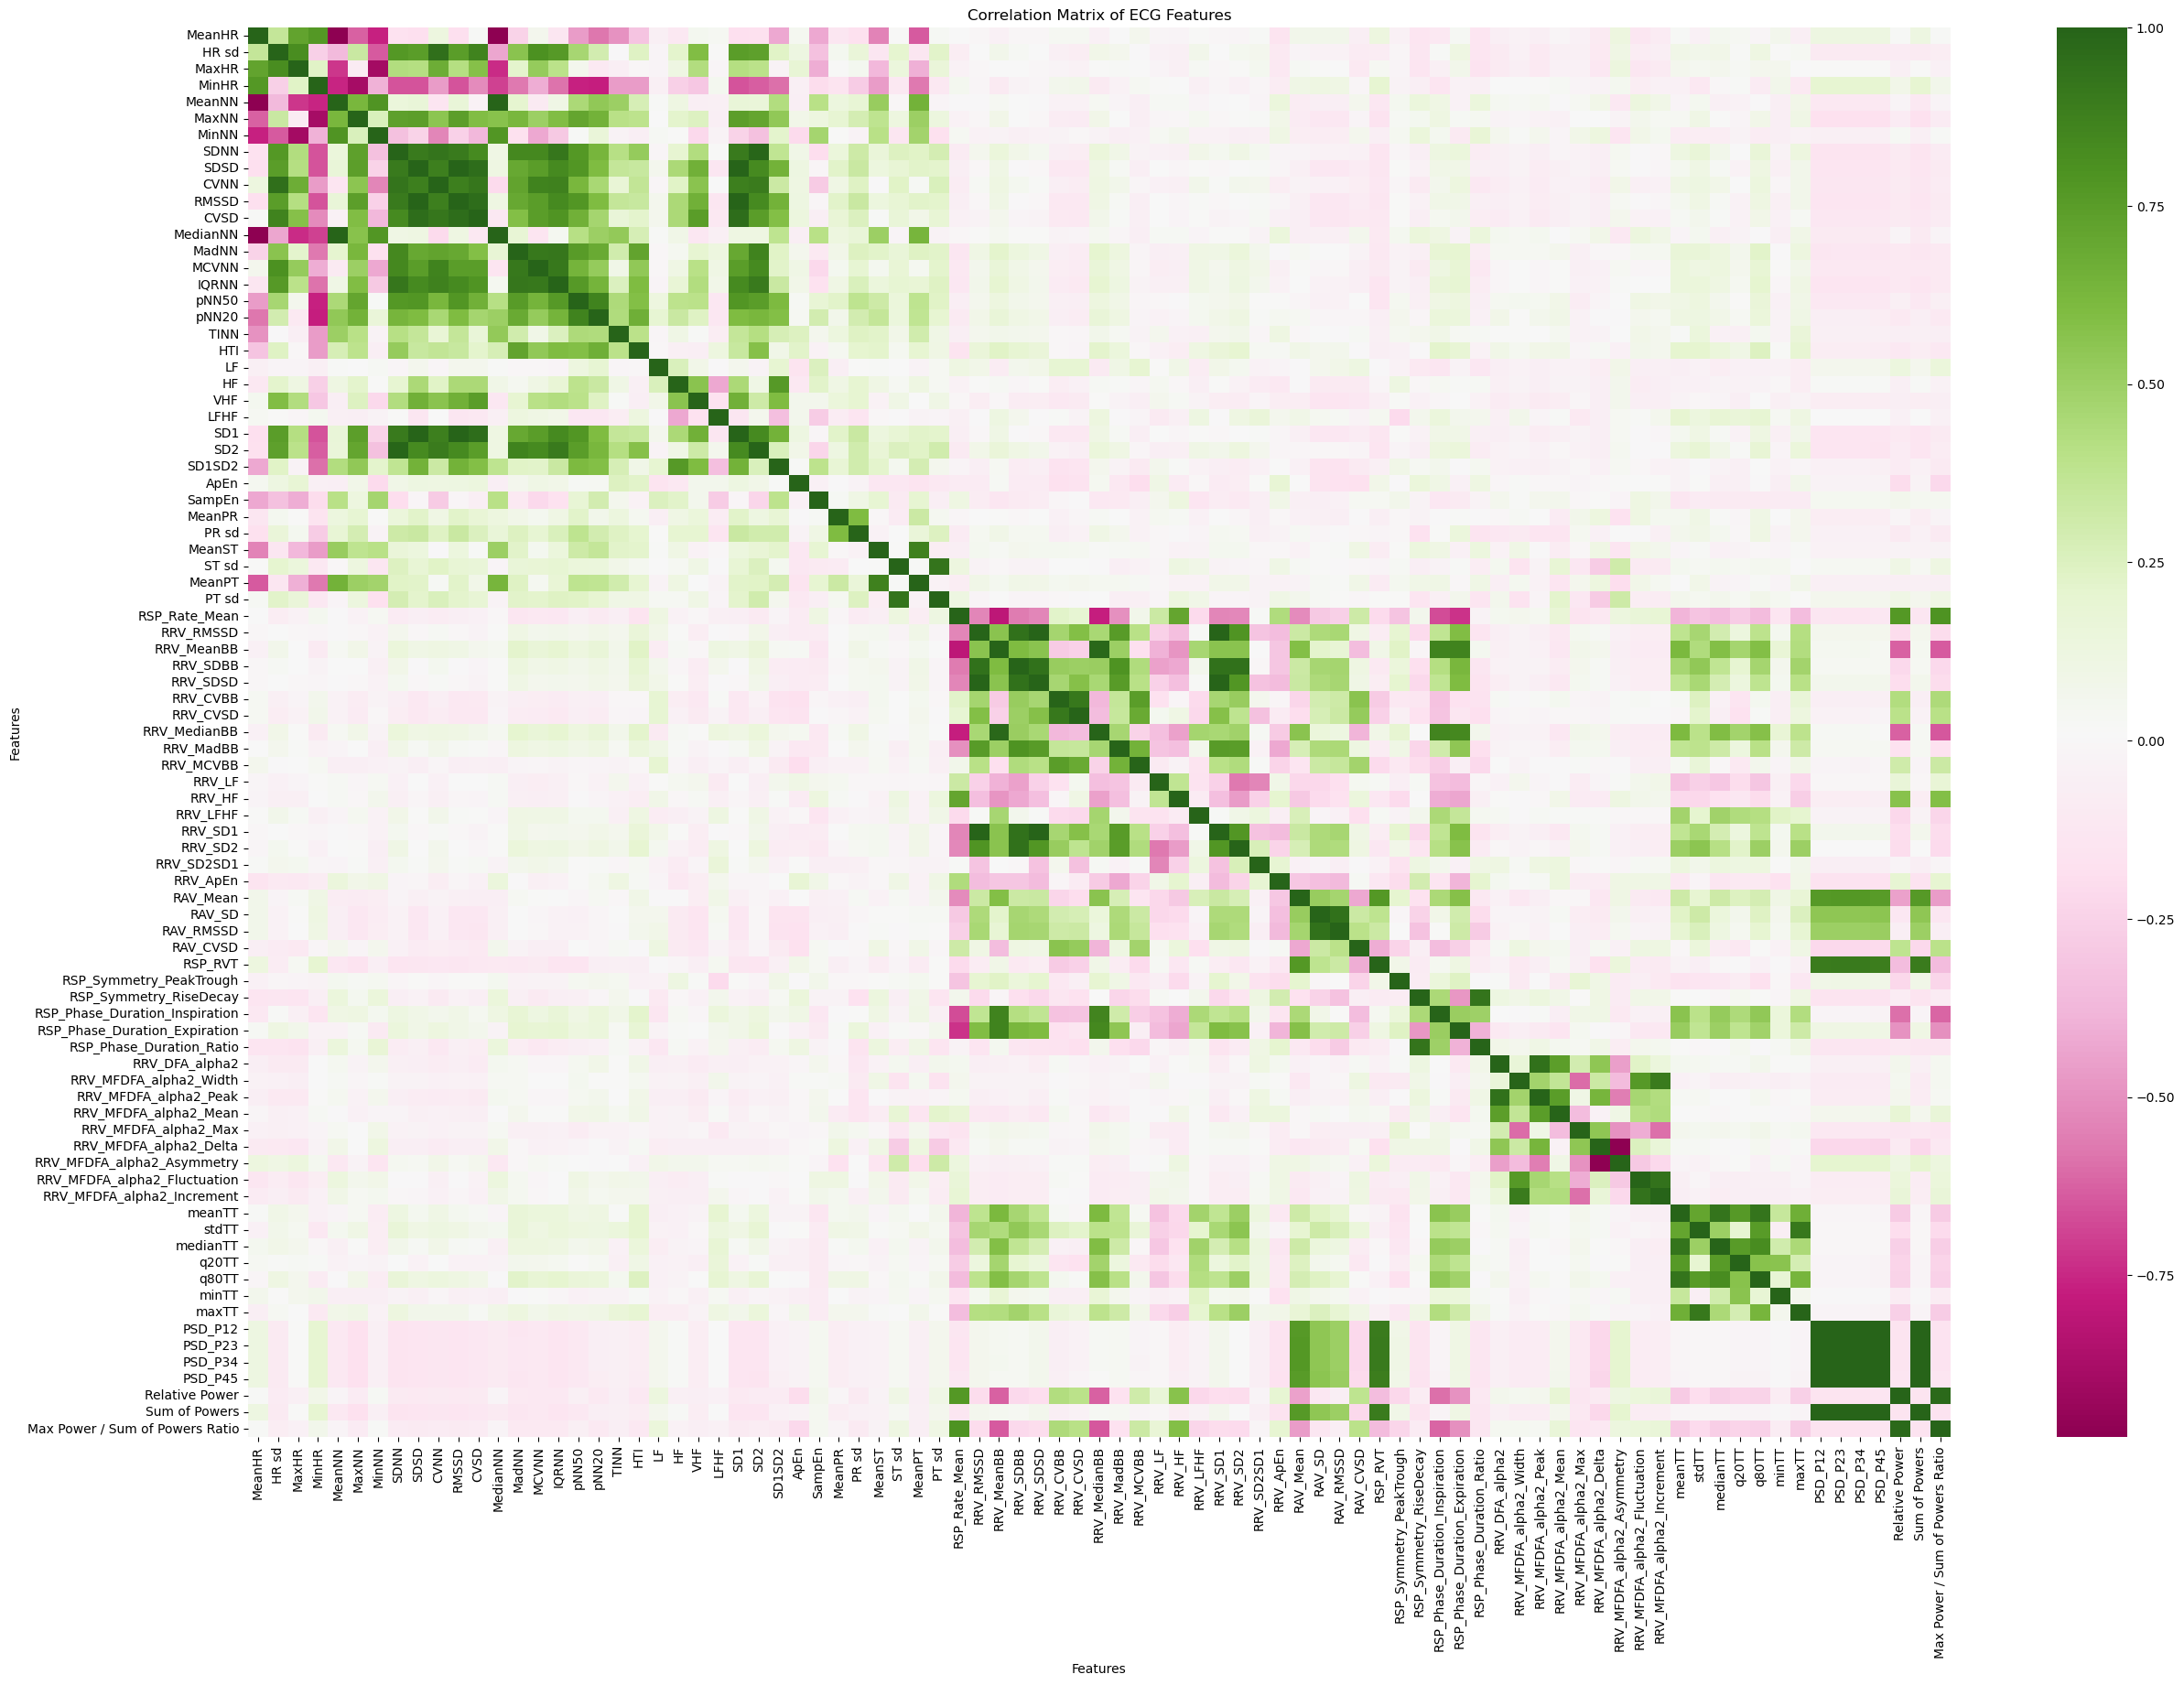

In [8]:
# Calculate the correlation matrix
#correlation_matrix = features.corr()
correlation_matrix = x_train.corr()

# Create a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', annot_kws=dict(size=15), cmap='PiYG')
plt.title('Correlation Matrix of ECG Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [9]:
def highlight_corr(values):
    color = 'red' if values >=0.9 else ''
    return f'background-color: {color}'
highlighted_corr = correlation_matrix.style.applymap(highlight_corr)
#highlighted_corr

In [10]:
#selection des motifs avec la matrice de correlation
corr_pairs=[]
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i,j]>0.9:
            corr_pairs.append((correlation_matrix.columns[i],correlation_matrix.columns[j],correlation_matrix.iloc[i,j]))
corr_pairs

[('SDSD', 'SDNN', 0.9068704540665219),
 ('CVNN', 'HR sd', 0.9469261885693822),
 ('CVNN', 'SDNN', 0.9283039786433678),
 ('RMSSD', 'SDNN', 0.9070945773526746),
 ('RMSSD', 'SDSD', 0.9999966704036962),
 ('CVSD', 'SDSD', 0.9554263050520907),
 ('CVSD', 'CVNN', 0.9175214721293066),
 ('CVSD', 'RMSSD', 0.9554774685038462),
 ('MedianNN', 'MeanNN', 0.9930293427189245),
 ('MCVNN', 'MadNN', 0.9077436066476219),
 ('IQRNN', 'SDNN', 0.9151288686262231),
 ('IQRNN', 'MadNN', 0.9166630498709476),
 ('IQRNN', 'MCVNN', 0.9103872451074255),
 ('SD1', 'SDNN', 0.9068704540665211),
 ('SD1', 'SDSD', 1.000000000000001),
 ('SD1', 'RMSSD', 0.9999966704036963),
 ('SD1', 'CVSD', 0.9554263050520881),
 ('SD2', 'SDNN', 0.9881953921416827),
 ('SD2', 'IQRNN', 0.9044933359715916),
 ('PT sd', 'ST sd', 0.9287845294506997),
 ('RRV_SDBB', 'RRV_RMSSD', 0.9421886228546947),
 ('RRV_SDSD', 'RRV_RMSSD', 0.9993367002471537),
 ('RRV_SDSD', 'RRV_SDBB', 0.9386723166685145),
 ('RRV_CVSD', 'RRV_CVBB', 0.9090417960199579),
 ('RRV_MedianBB'

In [11]:
features_to_drop = []
for i,j,k in corr_pairs:
    features_to_drop.append(j)
    
features_to_drop = list(set(features_to_drop))
features_to_drop

['RRV_DFA_alpha2',
 'SDNN',
 'RRV_CVBB',
 'IQRNN',
 'PSD_P45',
 'PSD_P23',
 'Relative Power',
 'PSD_P12',
 'RAV_SD',
 'RSP_Symmetry_RiseDecay',
 'PSD_P34',
 'RRV_MeanBB',
 'HR sd',
 'CVNN',
 'ST sd',
 'meanTT',
 'RRV_SDBB',
 'RRV_MFDFA_alpha2_Fluctuation',
 'SDSD',
 'RRV_RMSSD',
 'MCVNN',
 'RRV_SDSD',
 'MadNN',
 'stdTT',
 'MeanNN',
 'RMSSD',
 'CVSD']

In [12]:
x_train_selected = x_train.drop(features_to_drop,axis=1)
x_test_selected = x_test.drop(features_to_drop,axis=1)

In [13]:
#modele avec tous les motifs
logit = RandomForestClassifier()
logit.fit(x_train,y_train)
prediction = logit.predict(x_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74        89
         1.0       0.64      0.70      0.67        64

    accuracy                           0.71       153
   macro avg       0.71      0.71      0.71       153
weighted avg       0.72      0.71      0.71       153



In [17]:
#modele avec la selection des motifs
logitSelected = RandomForestClassifier()
logitSelected.fit(x_train_selected,y_train)
predSelected = logitSelected.predict(x_test_selected)
print(classification_report(y_test,predSelected))

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78        89
         1.0       0.70      0.72      0.71        64

    accuracy                           0.75       153
   macro avg       0.75      0.75      0.75       153
weighted avg       0.75      0.75      0.75       153

